Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.379EDM_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 180s 202ms/step - accuracy: 0.5056 - loss: 0.8153 - val_accuracy: 0.5043 - val_loss: 0.6931
Epoch 2/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - accuracy: 0.4959 - loss: 0.6949 - val_accuracy: 0.5054 - val_loss: 0.6931
Epoch 3/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5059 - val_loss: 0.6931
Epoch 4/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - accuracy: 0.4989 - loss: 0.7026 - val_accuracy: 0.4956 - val_loss: 0.6931
Epoch 5/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - accuracy: 0.4961 - loss: 0.6933 - val_accuracy: 0.4956 - val_loss: 0.6931
Epoch 6/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.4980 - loss: 0.6931 - val_accuracy: 0.4956 - val

Epoch 1/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5169 - loss: 0.7177 - val_accuracy: 0.5894 - val_loss: 0.6781
Epoch 2/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5468 - loss: 0.6833 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 3/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 4/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 5/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 6/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 7/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4926 - loss: 0.6932 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 8/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4959 - loss: 0.6932 - val_accuracy: 0.

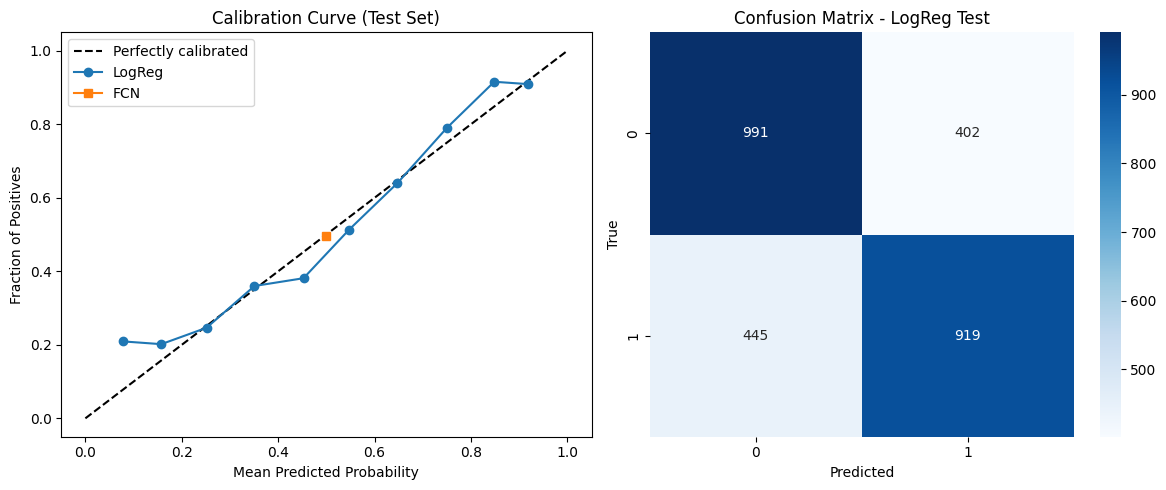

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

# Stage 1: Data Loading & Preprocessing (guaranteed non-empty splits)
def load_malaria_data():
    ds, info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)
    total = info.splits['train'].num_examples
    train_size = int(0.7 * total)
    val_size = int(0.2 * total)
    test_size = total - train_size - val_size
    ds = ds.take(total)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)
    return train_ds, val_ds, test_ds, total

def preprocess_image(image, label, target_size=224):
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    return image, label

train_ds, val_ds, test_ds, totalsamples = load_malaria_data()

batch_size = 32
train_ds = train_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Stage 2A: Model Creation
def create_efficientnetb3_extractor(input_shape=(224,224,3)):
    base = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base.layers[:-30]: layer.trainable = False
    for layer in base.layers[-30:]: layer.trainable = True
    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    return Model(inputs, x, name='EffnetB3Extractor')

def create_convnexttiny_extractor(input_shape=(224,224,3)):
    base = tf.keras.applications.ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base.layers[:-30]: layer.trainable = False
    for layer in base.layers[-30:]: layer.trainable = True
    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.convnext.preprocess_input(inputs)
    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    return Model(inputs, x, name='ConvNeXtTinyExtractor')

effnet_extractor = create_efficientnetb3_extractor()
convnext_extractor = create_convnexttiny_extractor()
extractors = [effnet_extractor, convnext_extractor]

# Stage 2B: Partial Fine-tuning
def finetune_extractors(extractors, train_ds, val_ds, epochs=15):
    for extractor in extractors:
        temp_input = layers.Input(shape=(224, 224, 3))
        features = extractor(temp_input)
        logits = layers.Dense(2, name='temp_classification_head')(features)
        temp_model = Model(inputs=temp_input, outputs=logits)
        temp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        temp_model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
        del temp_model

finetune_extractors(extractors, train_ds, val_ds, epochs=15)

# Stage 2C: Feature Extraction With Safeguard
def extract_features(model, dataset):
    features_list, labels_list = [], []
    for images, labels in dataset:
        features = model(images, training=False)
        features_list.append(features.numpy())
        labels_list.append(labels.numpy())
    # Error-proofing: safe empty outputs
    if len(features_list) > 0 and len(labels_list) > 0:
        features_out = np.concatenate(features_list)
        labels_out = np.concatenate(labels_list)
    else:
        features_out = np.zeros((0, 512))  # match model output dims
        labels_out = np.zeros((0,))
    return features_out, labels_out

train_effnet, train_labels = extract_features(effnet_extractor, train_ds)
val_effnet, val_labels = extract_features(effnet_extractor, val_ds)
test_effnet, test_labels = extract_features(effnet_extractor, test_ds)
train_convnext, _ = extract_features(convnext_extractor, train_ds)
val_convnext, _ = extract_features(convnext_extractor, val_ds)
test_convnext, _ = extract_features(convnext_extractor, test_ds)

# Stage 3: Fusion and Training
train_embeddings = np.concatenate([train_effnet, train_convnext], axis=1)
val_embeddings = np.concatenate([val_effnet, val_convnext], axis=1)
test_embeddings = np.concatenate([test_effnet, test_convnext], axis=1)

fusion_lr = LogisticRegression(max_iter=1000, random_state=42, verbose=0)
fusion_lr.fit(train_embeddings, train_labels)

fcn_model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1024,)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])
fcn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
fcn_model.fit(train_embeddings, train_labels, validation_data=(val_embeddings, val_labels), epochs=30, batch_size=32, verbose=1)

# Stage 4: Evaluation & Visualization
def evaluate_fusion(embeddings, labels, fusion_model, method_name):
    if embeddings.shape[0] == 0:
        return {"accuracy": None, "f1": None, "auc": None, "calibration": ([], []),
                "confusion": np.zeros((2,2)), "predictions": [], "probs": []}
    if isinstance(fusion_model, LogisticRegression):
        predictions = fusion_model.predict(embeddings)
        probabilities = fusion_model.predict_proba(embeddings)
    else:
        probabilities = fusion_model.predict(embeddings, verbose=0)
        predictions = np.argmax(probabilities, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    auc = roc_auc_score(labels, probabilities[:,1])
    fracpos, meanpred = calibration_curve(labels, probabilities[:,1], n_bins=10)
    cm = confusion_matrix(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "auc": auc,
        "calibration": (fracpos, meanpred),
        "confusion": cm,
        "predictions": predictions,
        "probs": probabilities
    }

test_metrics_lr = evaluate_fusion(test_embeddings, test_labels, fusion_lr, "Logistic Regression")
test_metrics_fcn = evaluate_fusion(test_embeddings, test_labels, fcn_model, "Small FCN")

print(f"Logistic Regression Test Set: Accuracy={test_metrics_lr['accuracy']}, F1-Score={test_metrics_lr['f1']}, ROC-AUC={test_metrics_lr['auc']}")
print(f"Small FCN Test Set: Accuracy={test_metrics_fcn['accuracy']}, F1-Score={test_metrics_fcn['f1']}, ROC-AUC={test_metrics_fcn['auc']}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
if len(test_metrics_lr['calibration'][1]) > 0:
    plt.plot(test_metrics_lr['calibration'][1], test_metrics_lr['calibration'][0], 'o-', label='LogReg')
if len(test_metrics_fcn['calibration'][1]) > 0:
    plt.plot(test_metrics_fcn['calibration'][1], test_metrics_fcn['calibration'][0], 's-', label='FCN')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Test Set)')
plt.legend()
plt.subplot(1,2,2)
sns.heatmap(test_metrics_lr['confusion'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LogReg Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()